In [5]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text, plot_tree
import matplotlib.pyplot as plt

In [ ]:
#sklearn decision tree method
class FedRateTree:
    def __init__(self, meeting_dates, initial_rate=4.25):
        self.meeting_dates = meeting_dates
        self.initial_rate = initial_rate
        self.scenarios = [-0.50, -0.25, 0.00]  # 50bp cut, 25bp cut, hold
        self.tree_data = self._build_tree_structure()
        
    def _build_tree_structure(self):
        """Create all possible paths through Fed meetings"""
        n_meetings = len(self.meeting_dates)
        
        # Generate all possible scenarios
        paths = []
        for i in range(3**n_meetings):  # 3 choices per meeting
            path = []
            temp = i
            for meeting in range(n_meetings):
                choice = temp % 3
                path.append(self.scenarios[choice])
                temp //= 3
            paths.append(path)
        
        # Convert to features (X) and targets (y)
        X = []  # [meeting_index, current_rate]
        y = []  # rate_change
        
        for path_idx, path in enumerate(paths):
            current_rate = self.initial_rate
            for meeting_idx, rate_change in enumerate(path):
                X.append([meeting_idx, current_rate])
                y.append(rate_change)
                current_rate += rate_change
                
        return np.array(X), np.array(y), paths
    
    def fit_market_probabilities(self, market_probs):
        """
        market_probs: dict like {meeting_idx: [prob_cut50, prob_cut25, prob_hold]}
        """
        X, y, paths = self.tree_data
        
        # Create sample weights based on market probabilities
        weights = []
        for path in paths:
            path_prob = 1.0
            current_rate = self.initial_rate
            
            for meeting_idx, rate_change in enumerate(path):
                # Get probability for this specific rate change
                if meeting_idx in market_probs:
                    probs = market_probs[meeting_idx]
                    if rate_change == -0.50:
                        path_prob *= probs[0]
                    elif rate_change == -0.25:
                        path_prob *= probs[1]
                    else:  # rate_change == 0.00
                        path_prob *= probs[2]
                current_rate += rate_change
            
            # Repeat weight for each step in this path
            for _ in path:
                weights.append(path_prob)
        
        # Fit sklearn tree with probability weights
        self.model = DecisionTreeRegressor(random_state=42, max_depth=10)
        self.model.fit(X, y, sample_weight=weights)
        
        return self
    
    def get_rate_probabilities(self, meeting_idx, current_rate):
        """Get probabilities for next rate decision"""
        # Predict for all three scenarios
        scenarios = []
        for rate_change in self.scenarios:
            pred = self.model.predict([[meeting_idx, current_rate]])
            scenarios.append(pred[0])
        
        # Convert to probabilities (this is simplified - you'd want more sophisticated logic)
        return dict(zip(self.scenarios, [0.33, 0.33, 0.34]))  # Placeholder
    
    def calculate_option_values(self, strikes, option_type='call'):
        """Calculate option values based on terminal rate distribution"""
        X, y, paths = self.tree_data
        
        # Get terminal rates for each path
        terminal_rates = []
        path_probs = []
        
        for path in paths:
            terminal_rate = self.initial_rate + sum(path)
            terminal_rates.append(terminal_rate)
            # Calculate path probability (simplified)
            path_probs.append(1.0 / len(paths))  # Equal weight for now
        
        # Calculate option payoffs
        option_values = {}
        for strike in strikes:
            payoffs = []
            for rate in terminal_rates:
                if option_type == 'call':
                    payoff = max(rate - strike, 0)
                else:
                    payoff = max(strike - rate, 0)
                payoffs.append(payoff)
            
            # Expected payoff
            option_values[strike] = np.average(payoffs, weights=path_probs)
        
        return option_values

Call option values: {3.5: np.float64(0.13888888888888892), 4.0: np.float64(0.00925925925925926), 4.5: np.float64(0.0), 5.0: np.float64(0.0)}
Put option values: {3.5: np.float64(0.13888888888888892), 4.0: np.float64(0.5092592592592594), 4.5: np.float64(1.0000000000000002), 5.0: np.float64(1.5000000000000002)}


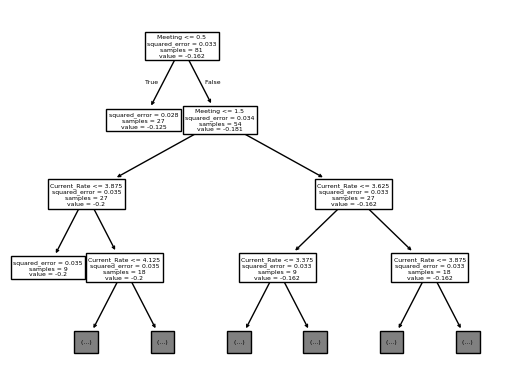

In [3]:
# Set up the tree
meeting_dates = ['2025-07-19', '2025-09-18', '2025-10-18']
fed_tree = FedRateTree(meeting_dates, initial_rate=4.25)

# Market-implied probabilities (from SOFR options)
market_probs = {
    0: [0.1, 0.3, 0.6],   # March: 10% 50bp cut, 30% 25bp cut, 60% hold
    1: [0.2, 0.4, 0.4],   # May: 20% 50bp cut, 40% 25bp cut, 40% hold  
    2: [0.15, 0.35, 0.5]  # June: 15% 50bp cut, 35% 25bp cut, 50% hold
}

# Fit to market
fed_tree.fit_market_probabilities(market_probs)

# Calculate option values
strikes = [3.5, 4.0, 4.5, 5.0]
call_values = fed_tree.calculate_option_values(strikes, 'call')
put_values = fed_tree.calculate_option_values(strikes, 'put')

print("Call option values:", call_values)
print("Put option values:", put_values)

# Visualize the tree structure
plot_tree(fed_tree.model, max_depth=3, feature_names=['Meeting', 'Current_Rate'])
plt.show()

In [9]:
#scipy stats method
from itertools import product

class FedRateModel:
    def __init__(self, initial_rate, n_meetings=3):
        self.initial_rate = initial_rate
        self.scenarios = [-0.50, -0.25, 0.00]  # 50bp cut, 25bp cut, hold
        self.n_meetings = n_meetings
        
    def generate_all_paths(self):
        """Generate all possible Fed rate paths"""
        # This creates all 27 combinations automatically
        all_paths = list(product(self.scenarios, repeat=self.n_meetings))
        
        terminal_rates = []
        for path in all_paths:
            terminal_rate = self.initial_rate + sum(path)
            terminal_rates.append(terminal_rate)
            
        return all_paths, terminal_rates
    
    def calculate_path_probabilities(self, meeting_probs):
        """
        meeting_probs: list of [prob_cut50, prob_cut25, prob_hold] for each meeting
        """
        all_paths, terminal_rates = self.generate_all_paths()
        
        path_probabilities = []
        for path in all_paths:
            prob = 1.0
            for meeting_idx, rate_change in enumerate(path):
                meeting_prob = meeting_probs[meeting_idx]
                
                if rate_change == -0.50:
                    prob *= meeting_prob[0]  # 50bp cut probability
                elif rate_change == -0.25:
                    prob *= meeting_prob[1]  # 25bp cut probability
                else:  # rate_change == 0.00
                    prob *= meeting_prob[2]  # hold probability
                    
            path_probabilities.append(prob)
        
        return all_paths, terminal_rates, path_probabilities
    
    def get_terminal_distribution(self, meeting_probs):
        """Get the probability distribution of terminal rates"""
        paths, terminal_rates, path_probs = self.calculate_path_probabilities(meeting_probs)
        
        # Group by terminal rate (some paths might end at same rate)
        rate_prob_dict = {}
        for rate, prob in zip(terminal_rates, path_probs):
            if rate in rate_prob_dict:
                rate_prob_dict[rate] += prob
            else:
                rate_prob_dict[rate] = prob
        
        rates = list(rate_prob_dict.keys())
        probs = list(rate_prob_dict.values())
        
        return rates, probs
    
    def calculate_option_values(self, strikes, meeting_probs, option_type='call'):
        """Calculate option values using direct probability calculation"""
        rates, probs = self.get_terminal_distribution(meeting_probs)
        
        option_values = {}
        for strike in strikes:
            expected_payoff = 0
            for rate, prob in zip(rates, probs):
                if option_type == 'call':
                    payoff = max(rate - strike, 0)
                else:
                    payoff = max(strike - rate, 0)
                expected_payoff += payoff * prob
            
            option_values[strike] = expected_payoff
            
        return option_values
    
    def compare_distributions(self, market_probs, your_probs):
        """Compare market vs your probability distributions"""
        market_rates, market_dist = self.get_terminal_distribution(market_probs)
        your_rates, your_dist = self.get_terminal_distribution(your_probs)
        
        # Use scipy.stats to compare distributions
        # Convert to common grid for comparison
        all_rates = sorted(set(market_rates + your_rates))
        
        market_pmf = [sum(p for r, p in zip(market_rates, market_dist) if r == rate) 
                     for rate in all_rates]
        your_pmf = [sum(p for r, p in zip(your_rates, your_dist) if r == rate) 
                   for rate in all_rates]
        
        # Calculate KL divergence to measure difference
        kl_div = stats.entropy(your_pmf, market_pmf)
        
        return {
            'rates': all_rates,
            'market_distribution': market_pmf,
            'your_distribution': your_pmf,
            'kl_divergence': kl_div
        }

In [10]:
# Initialize
model = FedRateModel(initial_rate=4.25, n_meetings=3)

# Market probabilities (from SOFR options)
market_probs = [
    [0.1, 0.3, 0.6],  # Meeting 1: 10% 50bp cut, 30% 25bp cut, 60% hold
    [0.2, 0.4, 0.4],  # Meeting 2: 20% 50bp cut, 40% 25bp cut, 40% hold
    [0.15, 0.35, 0.5] # Meeting 3: 15% 50bp cut, 35% 25bp cut, 50% hold
]

# Your view (more dovish than market)
your_probs = [
    [0.2, 0.4, 0.4],  # You think more cuts likely
    [0.3, 0.4, 0.3],  
    [0.25, 0.4, 0.35]
]

# Get terminal rate distributions
market_rates, market_dist = model.get_terminal_distribution(market_probs)
your_rates, your_dist = model.get_terminal_distribution(your_probs)

print("Market expects rates to end at:", dict(zip(market_rates, market_dist)))
print("You expect rates to end at:", dict(zip(your_rates, your_dist)))

# Calculate option values under both scenarios
strikes = [3.0, 3.5, 4.0, 4.5]
market_calls = model.calculate_option_values(strikes, market_probs, 'call')
your_calls = model.calculate_option_values(strikes, your_probs, 'call')

print("Market call values:", market_calls)
print("Your call values:", your_calls)

# Find arbitrage opportunities
for strike in strikes:
    diff = your_calls[strike] - market_calls[strike]
    if diff > 0.05:  # 5bp threshold
        print(f"BUY {strike} call: You value at {your_calls[strike]:.3f}, market at {market_calls[strike]:.3f}")
    elif diff < -0.05:
        print(f"SELL {strike} call: You value at {your_calls[strike]:.3f}, market at {market_calls[strike]:.3f}")

Market expects rates to end at: {2.75: 0.0030000000000000005, 3.0: 0.022, 3.25: 0.08700000000000001, 3.5: 0.20199999999999999, 3.75: 0.302, 4.0: 0.264, 4.25: 0.12}
You expect rates to end at: {2.75: 0.015, 3.0: 0.07400000000000001, 3.25: 0.18600000000000003, 3.5: 0.276, 3.75: 0.261, 4.0: 0.14600000000000002, 4.25: 0.041999999999999996}
Market call values: {3.0: 0.76325, 3.5: 0.2975, 4.0: 0.03, 4.5: 0.0}
Your call values: {3.0: 0.5787500000000001, 3.5: 0.16975, 4.0: 0.010499999999999999, 4.5: 0.0}
SELL 3.0 call: You value at 0.579, market at 0.763
SELL 3.5 call: You value at 0.170, market at 0.297


In [8]:
# Compare distributions statistically
from scipy.stats import wasserstein_distance, ks_2samp

# Measure how different your view is from market
distance = wasserstein_distance(market_rates, your_rates, market_dist, your_dist)

# Test if distributions are significantly different  
ks_stat, p_value = ks_2samp(market_rates, your_rates)